In [9]:
import os
from IPython.display import clear_output

import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader

from sklearn.model_selection import train_test_split

from ClusterDataset import ClusterDataset
from training import *
from GNN_TrackLinkingNet import GNN_TrackLinkingNet, weight_init

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the dataset
hist_folder_training = "/eos/user/c/czeh/histo/"
data_folder_training = "/eos/user/c/czeh/graph_data"

hist_folder_test = "/eos/user/c/czeh/histo_test/"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder_training)
dataset_test = ClusterDataset(data_folder_test, hist_folder_test)

In [4]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [5]:
model = GNN_TrackLinkingNet(input_dim = dataset_training.get(0).x.shape[1], 
                                edge_feature_dim=0,
                                edge_hidden_dim=16, hidden_dim=16, weighted_aggr=True)
                               #dropout=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
loss_obj = FocalLoss()

model.apply(weight_init)

/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

GNN_TrackLinkingNet(
  (inputnetwork): Sequential(
    (0): Linear(in_features=29, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (edge_inputnetwork): Sequential(
    (0): Linear(in_features=0, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (attention_direct): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (attention_reverse): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)


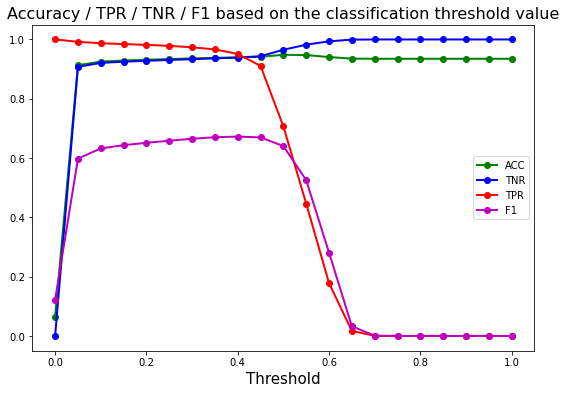

Chosen classification threshold is: 0.4
Edge labels: number of positive: 16000.0
Predictions: number of positive: 29260


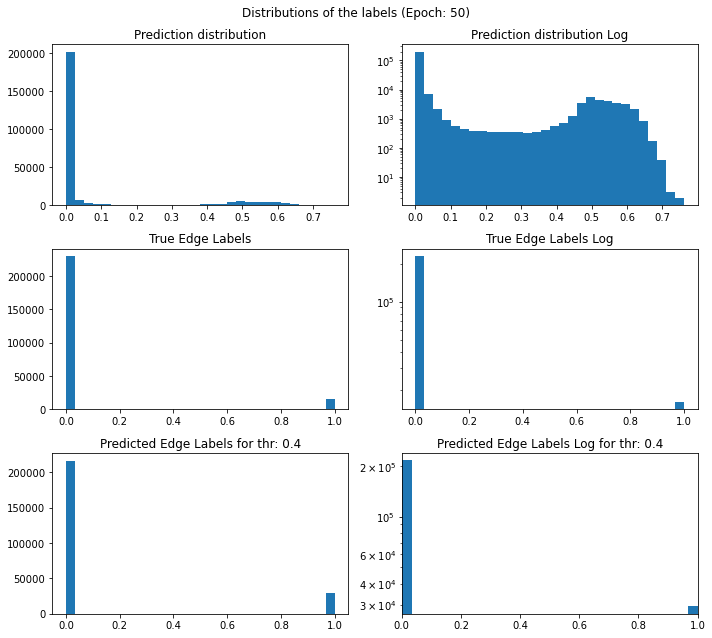

[4.43612903e-01 4.84595388e-01 4.78194356e-01 ... 4.25897124e-05
 5.06492768e-07 1.20128680e-05]
Confusion matrix:
[[215640  14041]
 [   781  15219]]

Confusion matrix weighted:
[[0.46943369 0.03056631]
 [0.02440625 0.47559375]]

TN: 215640 	 FN: 781 	 TP: 15219 	 FP: 14041
Confusion matrix scaled:
[[0.87772355 0.05715135]
 [0.00317892 0.06194618]]

Accuracy: 0.9397
Precision: 0.5201
Negative predictive value: 0.9964
Recall: Correctly classifying 95.1187 % of positive edges
True negative rate: Correctly classifying 93.8867 % of all negative edges
F1 score: 0.6725
[0.95057862 0.93961138] [0.93886739 0.9511875 ] [0.94468671 0.945364  ]
Balanced accuracy: 0.9450
Precision weighted: [0.95057862 0.93961138]
Recall weighted: [0.93886739 0.9511875 ]
F1 score weighted: [0.94468671 0.945364  ]
positive_likelihood_ratio: 15.559411451285522, negative_likelihood_ratio: 0.051990835709979595


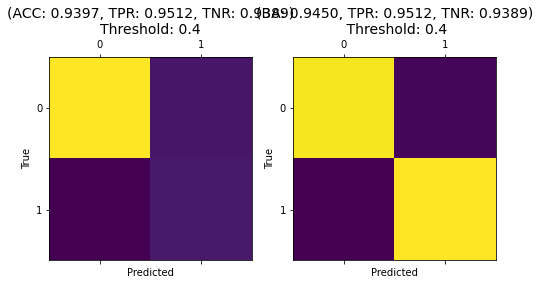

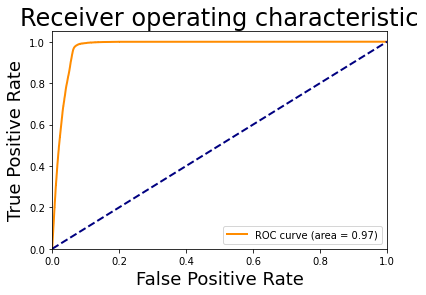

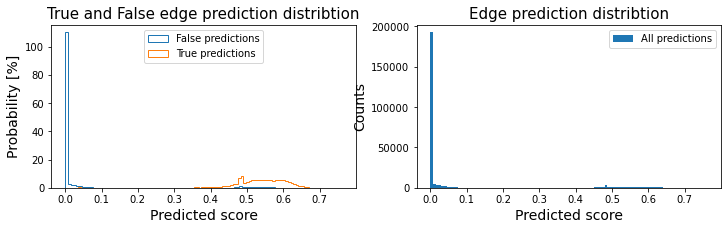

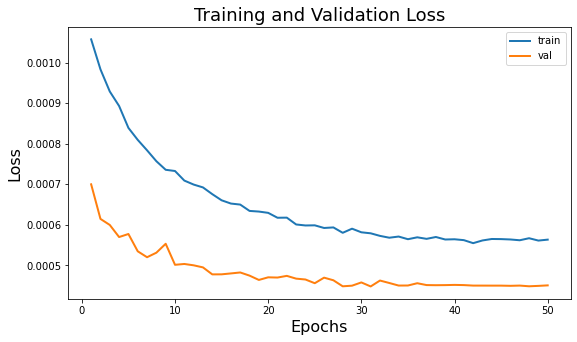

In [11]:
epochs = 50
decision_th = 0.5
os.makedirs(model_folder, exist_ok=True)

train_loss_hist = []
val_loss_hist = []
edge_features = False

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, epoch+1, device=device, edge_features=edge_features)
    train_loss_hist.append(loss)
    print(f'Epoch: {epoch+1}, train loss: {loss:.4f}')
    
    print(f">>> Saving model to {model_folder + f'/model_epoch_{epoch+1}_loss_{loss:.4f}.pt'}")
    torch.save({'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, model_folder + f'/model_epoch_{epoch+1}_loss_{loss:.4f}.pt')
    
    # Validation
    model.eval()
    pred, lab = [], []
    val_loss, j = 0, 0
    print("Validation step")
    for sample in tqdm(test_dl, desc="Validation"):
        sample = sample.to(device)
        
        if edge_features:
            if sample.edge_index.shape[1] != sample.edge_features.shape[0]:
                continue
            data = prepare_network_input_data(sample.x, sample.edge_index, sample.edge_features, device=device)
        else: 
            data = prepare_network_input_data(sample.x, sample.edge_index)
        #nn_pred, edge_emb = model(*data, device=device)
        nn_pred = model(*data, device=device)
        pred += nn_pred.tolist()
        lab += sample.y.tolist()
        val_loss += loss_obj(nn_pred, sample.y.float()).item()
        j += 1
        
    val_loss = float(val_loss)/j
    print(f'Epoch: {epoch+1}, val loss: {val_loss:.4f}')
    val_loss_hist.append(val_loss)
    clear_output(wait=True)
    
    TNR, TPR, thresholds = classification_thresholds_plot(np.array(pred), np.array(lab),
                                                          threshold_step=0.05, output_folder=model_folder,
                                                          epoch=epoch+1)
    classification_threshold = get_best_threshold(TNR, TPR, thresholds)
    print(f"Chosen classification threshold is: {classification_threshold}")

    plot_prediction_distribution_standard_and_log(np.array(pred), np.array(lab),
                                                  epoch=epoch+1, thr = classification_threshold,
                                                 folder=model_folder, val=True)

    test(np.array(lab), np.array(pred), classification_threshold=classification_threshold,
                        output_folder=model_folder, epoch=epoch+1)
    save_pred(np.array(pred), np.array(lab), epoch=epoch, out_folder=model_folder)
    save_loss(train_loss_hist, val_loss_hist, outputLossFunctionPath=model_folder)

    scheduler.step() 